In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/35-classes.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')


Mounted at /content/drive
Done


In [ ]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import pandas as pd

In [ ]:
training_path = '/content/35-classes/train/'
test_path = '/content/35-classes/test'
val_path = '/content/35-classes/val'
def transformDS1( batchSize, inputSize):

    training_transforms = transforms.Compose([transforms.Resize((inputSize,inputSize)),transforms.ToTensor()])
    train_dataset = torchvision.datasets.ImageFolder(root=training_path,transform = training_transforms)
    train_Loader = torch.utils.data.DataLoader(dataset = train_dataset,batch_size=batchSize,shuffle=False)

    mean, std = get_mean_std(train_Loader)

    train_transforms = transforms.Compose([
        transforms.Resize((inputSize,inputSize)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
    ])

    test_transforms = transforms.Compose([
        transforms.Resize((inputSize,inputSize)),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
    ])

    val_transforms = transforms.Compose([
        transforms.Resize((inputSize,inputSize)),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
    ])
    train_dataset = torchvision.datasets.ImageFolder(root=training_path,transform=train_transforms)
    test_dataset = torchvision.datasets.ImageFolder(root=test_path,transform=test_transforms)
    val_dataset = torchvision.datasets.ImageFolder(root=val_path,transform=val_transforms)


    data_loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batchSize,
    shuffle=True,drop_last=False,num_workers=0)
    data_loader_test = torch.utils.data.DataLoader(test_dataset, batch_size=batchSize,
    shuffle=True,drop_last=False,num_workers=0)
    data_loader_val = torch.utils.data.DataLoader(val_dataset, batch_size=batchSize,
    shuffle=True,drop_last=False,num_workers=0)

    return data_loader_train,data_loader_test,data_loader_val

def get_mean_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    for images,_ in loader:
        images_count_in_batch = images.size(0)
        images =images.view(images_count_in_batch,images.size(1),-1)
        mean+=images.mean(2).sum(0)
        std+=images.std(2).sum(0)
        total_images_count+=images_count_in_batch
    mean /= total_images_count
    std /= total_images_count
    return mean,std

def show_transformed_images(data_loader_train):
    batch=next(iter(data_loader_train))
    images,labels = batch
    grid = torchvision.utils.make_grid(images,nrow=3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid,(1,2,0)))
    plt.show()
    print("labels:",labels)

In [ ]:
train_loader,test_loader,val_loader = transformDS1(32,224)

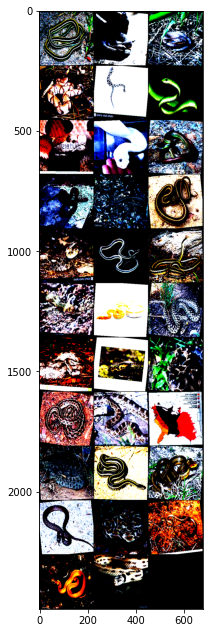

labels: tensor([32,  5, 10,  0, 25, 19,  0, 22,  2, 29, 21, 30, 24, 32, 32, 26, 24, 26,
        24,  1, 21, 31, 21, 24,  6, 33, 20, 28,  4, 13, 29, 11])


In [ ]:
show_transformed_images(train_loader)

In [ ]:
import torch.cuda


def set_device():
    if torch.cuda.is_available():
        device = "cuda:0"
    else:
        device = "cpu"
    return device

In [ ]:
def evaluate_model(model,test_loader):
    model.eval()
    predicted_correct =0
    total = 0
    device = set_device()
    with torch.no_grad():
        for data in test_loader:
            images,labels = data
            images = images.to(device)
            labels = labels.to(device)
            total+=labels.size(0)
            outputs = model(images)
            _,predicted = torch.max(outputs,1)
            predicted_correct += (predicted == labels).sum().item()
    epoch_accuracy = 100.0* predicted_correct/total
    print("Testing Data: Epoch Accuracy: %.3f"%(epoch_accuracy))
    return epoch_accuracy

In [ ]:
resnet_34 = models.resnet34(pretrained=False)
num_classes = 35
device = set_device()
num_filters = resnet_34.fc.in_features
resnet_34.fc = nn.Linear(num_filters, num_classes)
resnet_34 = resnet_34.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet_34.parameters(), lr=0.0002,momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0.0001)
epochCount=0
n_epochs = 20

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:

Accuracies = [] 
valAccuracies = []
total_steps = len(train_loader)
t1 = time.time()
device = set_device()
print("-----Device:"+device+"-----")
for epoch in range(n_epochs):
    print("Epoch number %d" %(epoch+1))
    resnet_34.train()
    running_loss = 0.0
    running_correct = 0.0
    total = 0
    for i, data in enumerate(train_loader):
        images,labels = data
        device = set_device()
        images = images.to(device)
        labels = labels.to(device)
        total+=labels.size(0)

        optimizer.zero_grad()
        outputs = resnet_34(images)
        _,predicted = torch.max(outputs.data,1)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        
        running_loss+=loss.item()
        running_correct += (labels==predicted).sum().item()
        if (i + 1) % 100 == 0:
          validation_accuracy = 0
          resnet_34.eval()
          with torch.no_grad(): 
              val_correct = 0
              val_total = 0
              for data in val_loader:
                  images, val_labels = data[0].to(device), data[1].to(device)
                  outputs = resnet_34(images)
                  
                  # Validation set accuracy
                  
                  _,predicted = torch.max(outputs.data, 1)
                  val_correct += (predicted == val_labels).sum().item()
                  val_total  += val_labels.size(0)

          validation_accuracy = (val_correct / val_total) * 100
          training_accuracy = (running_correct / total) * 100
          print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Training Accuracy: {:.2f}%, Validation Accuracy: {:.2f}%'
              .format(epoch + 1, n_epochs, i + 1, total_steps, loss.item(), training_accuracy , validation_accuracy))
      
    scheduler.step()
    epoch_loss = running_loss/len(train_loader)
    epoch_accuracy = 100.00 * running_correct/total
    Accuracies.append(epoch_accuracy)
    valAccuracies.append(validation_accuracy)
    print("Training Data: Epoch Loss: %.3f, Epoch Accuracy: %.3f"%(epoch_loss,epoch_accuracy))

print("---Training finished in {} seconds---".format(time.time()-t1))
epochCount+=n_epochs
torch.save(resnet_34.state_dict(), "/content/35-Class-"+str(epochCount)+"-epoch.pt")
test_acc = evaluate_model(resnet_34,test_loader)
dict = {'Training': Accuracies, 'Validation': valAccuracies} 
df = pd.DataFrame(dict)
df.to_csv("/content/Accuracies"+str(epochCount)+".csv")
from google.colab import files
files.download("/content/35-Class-"+str(epochCount)+"-epoch.pt")
files.download("/content/Accuracies"+str(epochCount)+".csv")

-----Device:cuda:0-----
Epoch number 1
Epoch [1/20], Step [100/288], Loss: 1.8882, Training Accuracy: 48.03%, Validation Accuracy: 515.50%
Epoch [1/20], Step [200/288], Loss: 1.4776, Training Accuracy: 49.28%, Validation Accuracy: 468.00%
Training Data: Epoch Loss: 1.798, Epoch Accuracy: 48.589
Epoch number 2
Epoch [2/20], Step [100/288], Loss: 1.6745, Training Accuracy: 48.62%, Validation Accuracy: 518.50%
Epoch [2/20], Step [200/288], Loss: 1.6505, Training Accuracy: 50.34%, Validation Accuracy: 474.50%
Training Data: Epoch Loss: 1.749, Epoch Accuracy: 50.076
Epoch number 3
Epoch [3/20], Step [100/288], Loss: 1.7567, Training Accuracy: 48.97%, Validation Accuracy: 528.00%
Epoch [3/20], Step [200/288], Loss: 1.7146, Training Accuracy: 50.70%, Validation Accuracy: 473.50%
Training Data: Epoch Loss: 1.713, Epoch Accuracy: 50.738
Epoch number 4
Epoch [4/20], Step [100/288], Loss: 1.6083, Training Accuracy: 50.69%, Validation Accuracy: 546.00%
Epoch [4/20], Step [200/288], Loss: 1.8200, T

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print("---Training finished in {} seconds---".format(time.time()-t1))
epochCount=20
torch.save(resnet_34.state_dict(), "/content/35-Class-"+str(epochCount)+"-epoch.pt")
test_acc = evaluate_model(resnet_34,test_loader)
dict = {'Training': Accuracies, 'Validation': valAccuracies} 
df = pd.DataFrame(dict)
df.to_csv("/content/Accuracies"+str(epochCount)+".csv")
from google.colab import files
files.download("/content/35-Class-"+str(epochCount)+"-epoch.pt")
files.download("/content/Accuracies"+str(epochCount)+".csv")

---Training finished in 3576.041778087616 seconds---
Testing Data: Epoch Accuracy: 16.890


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Plotting Accuracies Vs Epochs
plt.plot(range(n_epochs),Accuracies)
plt.xlabel("Epochs")
plt.ylabel("Training Accuracies")
plt.title("Training Accuracy Vs Epochs")
plt.show()

NameError: ignored

NameError: ignored

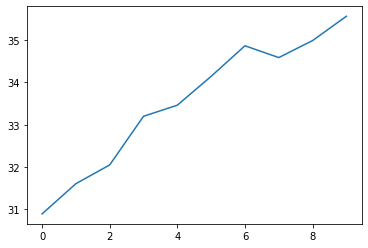

In [ ]:
# Plotting Validation Accuracies Vs Train Accuracies on Epochs
plt.plot(range(n_epochs),Accuracies, label="Training")
plt.plot(range(n_epochs),valAccuracies, label="Validation")
plt.xlable("Epochs")
plt.ylabel("Accuracies")
plt.title("Training vs Validation Accuracies")
plt.legend()
plt.show()


In [ ]:
from torchvision.models.resnet import resnet34
#Calculate Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        output = resnet34(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('0', '1', ' 2', ' 3', '4')

# Build confusion matrix
confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred),
                              display_labels=classes)
disp.plot()

plt.show()

NameError: ignored

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        output = resnet_34(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('0', '1', ' 2', ' 3', '4')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

NameError: ignored

In [ ]:
#Precision Calculation
from sklearn.metrics import precision_score
labels = labels.cpu()
predicted = predicted.cpu()
print("Precision Macro:"+ precision_score(labels, predicted, average='macro'))
print("Precision Micro:" + precision_score(labels,predicted,average='micro'))

0.5571428571428572